## Introduction

K-means clustering is one of the simplex clustering algorithm. Despite its simplicity, _k_-means is vastly used for clustering in many data science applications, especially useful if you need to quickly discover insights from unlabeled data.

Some real-world applications of _k_-means include:

-   Customer Segmentation,
-   Document Classification,
-   Delivery Store Optimization,
-   Image Segmentation etc.

In this notebook, we will learn Using _k_-means for customer segmentation.


In [2]:
# Import libraries
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

<a id='item1'></a>


<a id='item2'></a>


Imagine that you have a customer dataset, and you are interested in exploring the behavior of your customers using their historical data.

Customer segmentation is the practice of partitioning a customer base into groups of individuals that have similar characteristics. It is a significant strategy as a business can target these specific groups of customers and effectively allocate marketing resources. For example, one group might contain customers who are high-profit and low-risk, that is, more likely to purchase products, or subscribe to a service. A business task is to retain those customers. Another group might include customers from non-profit organizations, and so on.


### Download Dataset


https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/customer_segmentation.csv


In [3]:
#load dataset
data = pd.read_csv('data/customer_segmentation.csv')
data.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,Address,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,NBA001,6.3
1,2,47,1,26,100,4.582,8.218,0.0,NBA021,12.8
2,3,33,2,10,57,6.111,5.802,1.0,NBA013,20.9
3,4,29,2,4,19,0.681,0.516,0.0,NBA009,6.3
4,5,47,1,31,253,9.308,8.908,0.0,NBA008,7.2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Customer Id      850 non-null    int64  
 1   Age              850 non-null    int64  
 2   Edu              850 non-null    int64  
 3   Years Employed   850 non-null    int64  
 4   Income           850 non-null    int64  
 5   Card Debt        850 non-null    float64
 6   Other Debt       850 non-null    float64
 7   Defaulted        700 non-null    float64
 8   Address          850 non-null    object 
 9   DebtIncomeRatio  850 non-null    float64
dtypes: float64(4), int64(5), object(1)
memory usage: 66.5+ KB


### Pre-processing


As you can see, **Address** in this dataset is a categorical variable. k-means algorithm isn't directly applicable to categorical variables because Euclidean distance function isn't really meaningful for discrete variables. So, lets drop this feature and run clustering.


In [6]:
df = data.drop('Address', axis=1)
df.head()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
0,1,41,2,6,19,0.124,1.073,0.0,6.3
1,2,47,1,26,100,4.582,8.218,0.0,12.8
2,3,33,2,10,57,6.111,5.802,1.0,20.9
3,4,29,2,4,19,0.681,0.516,0.0,6.3
4,5,47,1,31,253,9.308,8.908,0.0,7.2


In [7]:
df.describe()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
count,850.00000,850.000000,850.000000,850.000000,850.000000,850.000000,850.000000,700.000000,850.000000
mean,425.50000,35.029412,1.710588,8.565882,46.675294,1.576820,3.078773,0.261429,10.171647
std,245.51816,8.041432,0.927784,6.777884,38.543054,2.125843,3.398799,0.439727,6.719441
min,1.00000,20.000000,1.000000,0.000000,13.000000,0.012000,0.046000,0.000000,0.100000
25%,213.25000,29.000000,1.000000,3.000000,24.000000,0.382500,1.045750,0.000000,5.100000
50%,425.50000,34.000000,1.000000,7.000000,35.000000,0.885000,2.003000,0.000000,8.700000
75%,637.75000,41.000000,2.000000,13.000000,55.750000,1.898500,3.903250,1.000000,13.800000
max,850.00000,56.000000,5.000000,33.000000,446.000000,20.561000,35.197000,1.000000,41.300000


Now let's normalize the dataset. But why do we need normalization in the first place? Normalization is a statistical method that helps mathematical-based algorithms interpret features with different magnitudes and distributions equally. We use **StandardScaler()** to normalize our dataset.


In [9]:
from sklearn.preprocessing import StandardScaler

X = df.values[:,1:]
X = np.nan_to_num(X)
scaled_dataset = StandardScaler().fit_transform(X)
scaled_dataset

array([[ 0.74291541,  0.31212243, -0.37878978, ..., -0.59048916,
        -0.52379654, -0.57652509],
       [ 1.48949049, -0.76634938,  2.5737211 , ...,  1.51296181,
        -0.52379654,  0.39138677],
       [-0.25251804,  0.31212243,  0.2117124 , ...,  0.80170393,
         1.90913822,  1.59755385],
       ...,
       [-1.24795149,  2.46906604, -1.26454304, ...,  0.03863257,
         1.90913822,  3.45892281],
       [-0.37694723, -0.76634938,  0.50696349, ..., -0.70147601,
        -0.52379654, -1.08281745],
       [ 2.1116364 , -0.76634938,  1.09746566, ...,  0.16463355,
        -0.52379654, -0.2340332 ]])

### Modeling


Let's run our model and group our customers into three clusters.

- n_init: Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.


In [10]:
from sklearn.cluster import KMeans 

num_clusters = 3
k_means = KMeans(n_clusters=num_clusters, n_init=12)
k_means.fit(scaled_dataset)
labels = k_means.labels_

print(labels)

[0 1 2 0 1 1 0 0 0 1 2 0 0 0 2 0 0 0 1 0 0 0 2 1 1 0 0 0 0 0 0 1 2 0 0 0 2
 2 0 1 2 1 0 1 0 1 0 0 0 0 1 1 2 0 2 2 2 0 0 0 1 0 1 1 0 0 0 2 0 2 0 0 0 0
 0 0 0 0 1 0 0 2 1 0 1 0 0 0 2 2 0 0 2 2 0 0 0 0 2 0 2 1 0 2 2 1 0 0 0 0 0
 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 1 0 0 2
 0 0 0 1 2 0 0 0 0 1 2 2 0 1 0 0 0 0 0 0 0 0 1 0 0 2 0 2 0 0 2 1 2 0 0 1 2
 1 0 0 0 0 0 1 0 2 0 0 0 1 1 0 1 0 2 0 0 2 0 1 0 2 0 0 0 0 0 2 2 1 0 0 2 1
 0 0 0 0 1 0 0 2 0 0 0 0 1 0 0 2 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 2 0 2 0
 0 0 1 0 2 1 2 0 1 0 0 2 0 0 0 0 2 2 2 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 2 0 0
 2 0 2 1 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 2 0 2 1 0 2 0 0 0 2 2 0 0 0 1 2
 0 0 2 0 1 0 0 0 0 0 2 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 2 0 2 0 0 0 1 1 0
 2 0 1 2 2 0 0 0 2 0 0 0 0 0 1 0 1 0 0 0 0 2 0 2 0 0 0 1 0 0 0 0 2 0 0 2 2
 1 0 0 0 0 0 2 2 0 1 2 1 0 0 2 0 0 1 1 0 2 0 0 1 0 2 0 1 0 0 0 1 0 0 0 0 1
 0 2 0 0 0 0 1 2 0 0 1 0 2 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 2 0 0 0 2 0
 2 0 0 0 0 0 1 2 2 0 1 0 

<h2 id="insights">Insights</h2>


Note that each row in our dataset represents a customer, and therefore, each row is assigned a label.


In [14]:
df["Labels"] = labels
df.sample(10)

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio,Labels
154,155,34,2,9,65,2.108,1.922,0.0,6.2,0
571,572,40,3,5,220,8.166,27.034,1.0,16.0,1
686,687,23,2,1,18,0.885,2.481,1.0,18.7,2
645,646,39,2,9,56,4.765,5.707,0.0,18.7,1
543,544,49,1,11,39,2.458,1.481,0.0,10.1,0
178,179,29,2,5,36,3.491,0.973,1.0,12.4,2
55,56,34,1,2,25,0.573,2.577,1.0,12.6,2
180,181,39,2,2,46,4.004,3.356,1.0,16.0,2
32,33,23,2,0,42,1.019,0.619,1.0,3.9,2
629,630,45,3,8,140,4.184,15.276,NaN,13.9,1


We can easily check the centroid values by averaging the features in each cluster.


In [15]:
df.groupby('Labels').mean()

,Customer Id,Age,Edu,Years Employed,Income,Card Debt,Other Debt,Defaulted,DebtIncomeRatio
Labels,,,,,,,,,
0,426.122905,33.817505,1.603352,7.625698,36.143389,0.853128,1.816855,0.000000,7.964991
1,424.408163,43.000000,1.931973,17.197279,101.959184,4.220673,7.954483,0.162393,13.915646
2,424.451807,31.891566,1.861446,3.963855,31.789157,1.576675,2.843355,0.993939,13.994578


<em>k</em>-means will partition your customers into three groups since we specified the algorithm to generate 3 clusters. The customers in each cluster are similar to each other in terms of the features included in the dataset.


C:\Python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


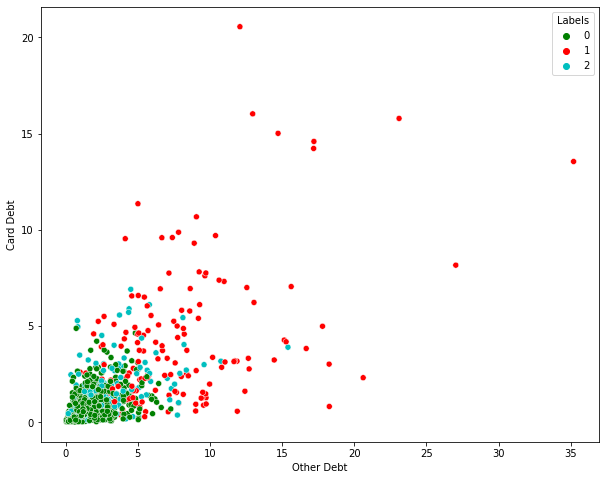

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize= (10, 8))
sns.scatterplot(df['Other Debt'],df['Card Debt'], hue=df['Labels'], palette=['g', 'r', 'c'])
plt.show()


## You can Try
Perform PCA on feature and try to visualize the clusters